In [1]:
import sys
import numpy             as     np
import pylab             as     pl
import matplotlib.pyplot as     plt

In [2]:
sys.path.append('/global/homes/m/mjwilson/desi/BGS/lumfn/py/lumfn/')
sys.path.append('/global/homes/m/mjwilson/desi/BGS/lumfn/py/')

In [3]:
from schechter           import schechters, mxxl_schechter, schechter, mxxl_kernel, mxxl_phistar, schechter_prob
from scipy.interpolate   import interp1d
from scipy.misc          import derivative
from scipy.optimize      import brentq
from mxxl_ecorr          import mxxl_ecorr
from distances           import dist_mod, comoving_volume, comoving_distance, cosmo
from zlimits             import kmax
from astropy.table       import Table, vstack
from ajs_kcorr           import ajs_kcorr
from params              import params
from zlimits             import zmin
from astropy.cosmology   import z_at_value

In [4]:
rlim = 19.5
zref = 0.1
dM   = 1.e-5
Mmax = -30.

In [5]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [6]:
ps   = {}
rps  = {}
nrps = {}

dz   = 0.1
zs   = np.arange(0.1, 0.6, dz)

ref_Mmins = []

for zz in zs:
    # Minimum absolute mag. visible at this redshift (100% complete).
    Mmin     = rlim - dist_mod(zz) - kmax(zz)
    
    Ms       = np.arange(Mmax, Mmin+dM, dM) # [::-1]
    
    def solve_refMmin():
        tmin, norm, err, phistar = schechter_prob(Ms, named_type='LovedayMock', zz=zz, Mmin=Mmin, norm_only=True)

        target = norm * phistar
    
        def diff(x):
            tmin, norm, err, phistar = schechter_prob(Ms, named_type='LovedayMock', zz=0.1, Mmin=x, norm_only=True)    
            return target - norm * phistar 

        result = brentq(diff, Mmin - 5., Mmin + 5.)

        return result
    
    ref_Mmin = solve_refMmin()
    ref_Ms   = np.arange(Mmax, ref_Mmin+dM, dM)

    ref_Mmins.append(ref_Mmin)
    
    ps[zz]   = schechter_prob(ref_Ms, named_type='LovedayMock', zz=0.1, Mmin=ref_Mmin)
    nrps[zz] = interp1d(dM * np.cumsum(ps[zz]), ref_Ms, bounds_error=False, fill_value=(ref_Ms[0], ref_Ms[-1]))
        
    ps[zz]   = schechter_prob(Ms, named_type='LovedayMock', zz=zz, Mmin=Mmin)
    rps[zz]  = interp1d(dM * np.cumsum(ps[zz]), Ms, bounds_error=False, fill_value=(Ms[0], Ms[-1]))
    
    ps[zz]   = interp1d(Ms, dM * np.cumsum(ps[zz]), bounds_error=False, fill_value=(0.0, 1.0))
    
    print('{:.3f} \t {:.3f} \t {:.3f}'.format(zz, Mmin, ref_Mmin))

0.100 	 -17.945 	 -17.945
0.200 	 -19.747 	 -19.508
0.300 	 -20.922 	 -20.586
0.400 	 -21.888 	 -21.512
0.500 	 -22.861 	 -22.469


In [7]:
ref_Mmins = np.array(ref_Mmins)
ref_Mmins

array([-17.94534819, -19.50784755, -20.5856351 , -21.51221925,
       -22.46925886])

In [8]:
Cs = np.logspace(-30., 0., 150)
Cs

array([1.00000000e-30, 1.58979923e-30, 2.52746159e-30, 4.01815648e-30,
       6.38806207e-30, 1.01557362e-29, 1.61455815e-29, 2.56682330e-29,
       4.08073370e-29, 6.48754729e-29, 1.03138977e-28, 1.63970266e-28,
       2.60679802e-28, 4.14428548e-28, 6.58858186e-28, 1.04745224e-27,
       1.66523876e-27, 2.64739529e-27, 4.20882699e-27, 6.69118990e-27,
       1.06376485e-26, 1.69117254e-26, 2.68862481e-26, 4.27437364e-26,
       6.79539592e-26, 1.08033152e-25, 1.71751022e-25, 2.73049642e-25,
       4.34094109e-25, 6.90122480e-25, 1.09715619e-24, 1.74425806e-24,
       2.77302012e-24, 4.40854524e-24, 7.00870182e-24, 1.11424288e-23,
       1.77142246e-23, 2.81620607e-23, 4.47720223e-23, 7.11785265e-23,
       1.13159567e-22, 1.79900992e-22, 2.86006458e-22, 4.54692846e-22,
       7.22870335e-22, 1.14921870e-21, 1.82702700e-21, 2.90460612e-21,
       4.61774057e-21, 7.34128040e-21, 1.16711619e-20, 1.85548042e-20,
       2.94984134e-20, 4.68965549e-20, 7.45561067e-20, 1.18529241e-19,
      

(1e-06, 0.03)

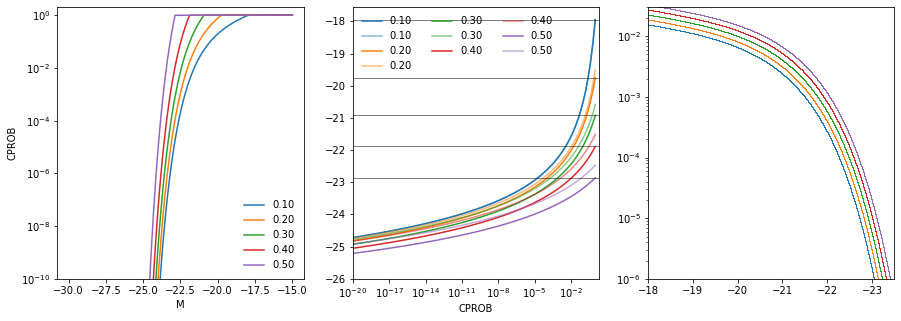

In [9]:
fig, axes   = plt.subplots(1, 3, figsize=(15,5))

for zz, color in zip(zs, colors):    
    Ms      = np.arange(Mmax, -15., dM)[::-1]
    
    Mmin    = rlim - dist_mod(zz) - kmax(zz)
    
    phis    = schechter(Ms, named_type='LovedayMock', zz=zz)
    
    axes[0].plot(Ms,   ps[zz](Ms), label='{:.2f}'.format(zz))
    
    axes[1].plot(Cs,  rps[zz](Cs), label='{:.2f}'.format(zz), c=color)
    axes[1].plot(Cs, nrps[zz](Cs), label='{:.2f}'.format(zz), linestyle='-', c=color, alpha=0.55)

    axes[1].axhline(Mmin, c='k', lw=0.5)
    
    axes[2].semilogy(Ms, phis, marker=',', label='{:.2f}'.format(zz), lw=0.0)
    
axes[0].set_ylim(-0.05, 1.05)    
axes[0].legend(frameon=False, loc=4)
axes[0].set_xlabel('M')
axes[0].set_yscale('log')
axes[0].set_ylim(1.e-10, 2.e0)
axes[0].set_ylabel('CPROB')

axes[1].set_xlim(1.e-20, 2.)
axes[1].set_xlabel('CPROB')
axes[1].legend(frameon=False, loc=2, ncol=3)
axes[1].set_xscale('log')

axes[2].set_xlim(-18.,  -23.5)
axes[2].set_ylim(1.e-6, 3.e-2)

In [10]:
result = [] 
names  = ['CPROB'] 

for zz in zs:
    names += ['MZ{:.1f}'.format(zz), 'REFMZ{:.1f}'.format(zz)]
    
for C in Cs:
    row  = [C]

    for zz in zs:
        row += [rps[zz](C), nrps[zz](C)]

    result.append(row)
    
result = Table(np.array(result), names=names)
result

CPROB,MZ0.1,REFMZ0.1,MZ0.2,REFMZ0.2,MZ0.3,REFMZ0.3,MZ0.4,REFMZ0.4,MZ0.5,REFMZ0.5
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1e-30,-25.1974767015963,-25.1974767015963,-25.289007164696464,-25.216252346429123,-25.383440780568495,-25.238045120588037,-25.48775463679739,-25.269899833446402,-25.619779764375565,-25.329869442463277
1.5897992284504805e-30,-25.18960347994477,-25.18960347994477,-25.28128623331232,-25.208512092521676,-25.37588916009363,-25.230456428837954,-25.480434629132475,-25.262527433739656,-25.61286077595288,-25.322887866559856
2.5274615867817217e-30,-25.181673833413548,-25.181673833413548,-25.273511026108217,-25.20071729299096,-25.36828560616858,-25.22281529498056,-25.47306580772014,-25.255105522485188,-25.605898150044446,-25.31586186369653
4.018156480603808e-30,-25.173686954979257,-25.173686954979257,-25.265680782593822,-25.1928671805749,-25.36062940446967,-25.21512099514812,-25.465647522767053,-25.247633436224135,-25.598891336844897,-25.308790869864456
6.388062072657232e-30,-25.16564202042737,-25.16564202042737,-25.257794725577405,-25.184960971767683,-25.352919829085895,-25.207372792483223,-25.45817911165872,-25.240110497786052,-25.591839776827943,-25.301674310990116
1.015573615440416e-29,-25.157538187878444,-25.157538187878444,-25.24985205984678,-25.17699786758464,-25.345156137795136,-25.19956993170819,-25.45065989869423,-25.232536018115688,-25.584742900724,-25.29451159937066
1.614558150261838e-29,-25.14937459714272,-25.14937459714272,-25.241851975559577,-25.16897705033429,-25.33733757099326,-25.191711645275635,-25.443089194535027,-25.22490929026139,-25.5776001251563,-25.287302138989855
2.566823301574684e-29,-25.141150367771523,-25.141150367771523,-25.233793644432446,-25.1608976853069,-25.329463355775125,-25.18379714639445,-25.435466295361255,-25.217229596569187,-25.570410859708133,-25.280045320560053
4.080733704412147e-29,-25.132864603122652,-25.132864603122652,-25.225676219838785,-25.1527589198119,-25.32153270131835,-25.175825632810728,-25.42779048172857,-25.20949620320071,-25.56317449992865,-25.272740522177212


In [11]:
for i, zz in enumerate(zs):        
    #  E(z)                 = M(z) - ^0.1 M
    result['E{:.1f}'.format(zz)] = result['MZ{:.1f}'.format(zz)] - result['REFMZ{:.1f}'.format(zz)]

In [12]:
result

CPROB,MZ0.1,REFMZ0.1,MZ0.2,REFMZ0.2,MZ0.3,REFMZ0.3,MZ0.4,REFMZ0.4,MZ0.5,REFMZ0.5,E0.1,E0.2,E0.3,E0.4,E0.5
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1e-30,-25.1974767015963,-25.1974767015963,-25.289007164696464,-25.216252346429123,-25.383440780568495,-25.238045120588037,-25.48775463679739,-25.269899833446402,-25.619779764375565,-25.329869442463277,0.0,-0.07275481826734165,-0.14539565998045845,-0.2178548033509884,-0.2899103219122878
1.5897992284504805e-30,-25.18960347994477,-25.18960347994477,-25.28128623331232,-25.208512092521676,-25.37588916009363,-25.230456428837954,-25.480434629132475,-25.262527433739656,-25.61286077595288,-25.322887866559856,0.0,-0.07277414079064215,-0.1454327312556778,-0.21790719539281866,-0.2899729093930219
2.5274615867817217e-30,-25.181673833413548,-25.181673833413548,-25.273511026108217,-25.20071729299096,-25.36828560616858,-25.22281529498056,-25.47306580772014,-25.255105522485188,-25.605898150044446,-25.31586186369653,0.0,-0.07279373311725834,-0.14547031118802067,-0.2179602852349518,-0.29003628634791667
4.018156480603808e-30,-25.173686954979257,-25.173686954979257,-25.265680782593822,-25.1928671805749,-25.36062940446967,-25.21512099514812,-25.465647522767053,-25.247633436224135,-25.598891336844897,-25.308790869864456,0.0,-0.07281360201892184,-0.1455084093215504,-0.21801408654291876,-0.2901004669804408
6.388062072657232e-30,-25.16564202042737,-25.16564202042737,-25.257794725577405,-25.184960971767683,-25.352919829085895,-25.207372792483223,-25.45817911165872,-25.240110497786052,-25.591839776827943,-25.301674310990116,0.0,-0.07283375380972146,-0.14554703660267165,-0.21806861387266707,-0.290165465837827
1.015573615440416e-29,-25.157538187878444,-25.157538187878444,-25.24985205984678,-25.17699786758464,-25.345156137795136,-25.19956993170819,-25.45065989869423,-25.232536018115688,-25.584742900724,-25.29451159937066,0.0,-0.07285419226214174,-0.1455862060869464,-0.21812388057854193,-0.2902313013533373
1.614558150261838e-29,-25.14937459714272,-25.14937459714272,-25.241851975559577,-25.16897705033429,-25.33733757099326,-25.191711645275635,-25.443089194535027,-25.22490929026139,-25.5776001251563,-25.287302138989855,0.0,-0.07287492522528538,-0.14562592571762423,-0.21817990427363654,-0.290297986166447
2.566823301574684e-29,-25.141150367771523,-25.141150367771523,-25.233793644432446,-25.1608976853069,-25.329463355775125,-25.18379714639445,-25.435466295361255,-25.217229596569187,-25.570410859708133,-25.280045320560053,0.0,-0.07289595912554603,-0.14566620938067487,-0.21823669879206875,-0.2903655391480804
4.080733704412147e-29,-25.132864603122652,-25.132864603122652,-25.225676219838785,-25.1527589198119,-25.32153270131835,-25.175825632810728,-25.42779048172857,-25.20949620320071,-25.56317449992865,-25.272740522177212,0.0,-0.07291730002688368,-0.1457070685076225,-0.21829427852786054,-0.2904339777514373


0 	 0.1000 	 -17.9453 	 -20.7000
1 	 0.2000 	 -19.7473 	 -20.7700
2 	 0.3000 	 -20.9217 	 -20.8400
3 	 0.4000 	 -21.8880 	 -20.9100
4 	 0.5000 	 -22.8609 	 -20.9800


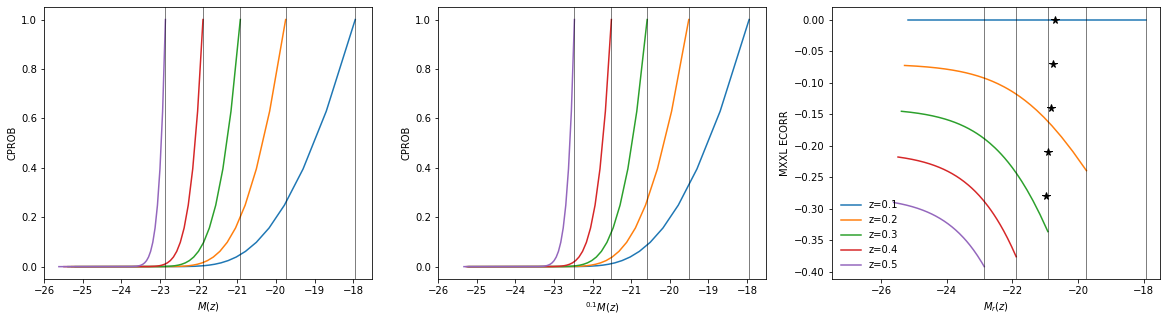

In [13]:
fig, axes   = plt.subplots(1, 3, figsize=(20,5))

for i, zz in enumerate(zs):    
    Mz                      = result['MZ{:.1f}'.format(zz)]
    Mzref                   = result['REFMZ{:.1f}'.format(zz)]
    
    #  E(z)                 = M(z) - ^0.1 M
    Ezz                     = Mz - Mzref
    
    Mmin                    = rlim - dist_mod(zz) - kmax(zz) 
    
    (Mstar, phistar, alpha) = schechter(None, named_type='LovedayMock', zz=zz, only_params=True)

    axes[0].plot(Mz, Cs)
    axes[0].axvline(Mmin, c='k', lw=0.5)
    
    axes[1].plot(Mzref, Cs)
    axes[1].axvline(ref_Mmins[i], c='k', lw=0.5)
    
    axes[2].plot(Mz, Ezz, label='z={:.1f}'.format(zz))    
    axes[2].plot(Mstar, -0.70 * (zz - zref), c='black', lw=0.0, marker='*', markersize=7.5)
    axes[2].axvline(Mmin, c='k', lw=0.5)
    
    print('{:d} \t {:.4f} \t {:.4f} \t {:.4f}'.format(i, zz, Mmin,  Mstar))

axes[0].set_xlabel('$M(z)$')
axes[0].set_ylabel('CPROB')
axes[0].set_xlim(-26., -17.5)
    
axes[1].set_xlabel('$^{0.1} M(z)$')
axes[1].set_ylabel('CPROB')
axes[1].set_xlim(-26., -17.5)
    
axes[2].set_xlim(-27.5, -17.5)
axes[2].set_xlabel(r'$M_r(z)$')
axes[2].set_ylabel('MXXL ECORR')

axes[2].legend(frameon=False, loc=3, ncol=1)

In [14]:
result

CPROB,MZ0.1,REFMZ0.1,MZ0.2,REFMZ0.2,MZ0.3,REFMZ0.3,MZ0.4,REFMZ0.4,MZ0.5,REFMZ0.5,E0.1,E0.2,E0.3,E0.4,E0.5
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1e-30,-25.1974767015963,-25.1974767015963,-25.289007164696464,-25.216252346429123,-25.383440780568495,-25.238045120588037,-25.48775463679739,-25.269899833446402,-25.619779764375565,-25.329869442463277,0.0,-0.07275481826734165,-0.14539565998045845,-0.2178548033509884,-0.2899103219122878
1.5897992284504805e-30,-25.18960347994477,-25.18960347994477,-25.28128623331232,-25.208512092521676,-25.37588916009363,-25.230456428837954,-25.480434629132475,-25.262527433739656,-25.61286077595288,-25.322887866559856,0.0,-0.07277414079064215,-0.1454327312556778,-0.21790719539281866,-0.2899729093930219
2.5274615867817217e-30,-25.181673833413548,-25.181673833413548,-25.273511026108217,-25.20071729299096,-25.36828560616858,-25.22281529498056,-25.47306580772014,-25.255105522485188,-25.605898150044446,-25.31586186369653,0.0,-0.07279373311725834,-0.14547031118802067,-0.2179602852349518,-0.29003628634791667
4.018156480603808e-30,-25.173686954979257,-25.173686954979257,-25.265680782593822,-25.1928671805749,-25.36062940446967,-25.21512099514812,-25.465647522767053,-25.247633436224135,-25.598891336844897,-25.308790869864456,0.0,-0.07281360201892184,-0.1455084093215504,-0.21801408654291876,-0.2901004669804408
6.388062072657232e-30,-25.16564202042737,-25.16564202042737,-25.257794725577405,-25.184960971767683,-25.352919829085895,-25.207372792483223,-25.45817911165872,-25.240110497786052,-25.591839776827943,-25.301674310990116,0.0,-0.07283375380972146,-0.14554703660267165,-0.21806861387266707,-0.290165465837827
1.015573615440416e-29,-25.157538187878444,-25.157538187878444,-25.24985205984678,-25.17699786758464,-25.345156137795136,-25.19956993170819,-25.45065989869423,-25.232536018115688,-25.584742900724,-25.29451159937066,0.0,-0.07285419226214174,-0.1455862060869464,-0.21812388057854193,-0.2902313013533373
1.614558150261838e-29,-25.14937459714272,-25.14937459714272,-25.241851975559577,-25.16897705033429,-25.33733757099326,-25.191711645275635,-25.443089194535027,-25.22490929026139,-25.5776001251563,-25.287302138989855,0.0,-0.07287492522528538,-0.14562592571762423,-0.21817990427363654,-0.290297986166447
2.566823301574684e-29,-25.141150367771523,-25.141150367771523,-25.233793644432446,-25.1608976853069,-25.329463355775125,-25.18379714639445,-25.435466295361255,-25.217229596569187,-25.570410859708133,-25.280045320560053,0.0,-0.07289595912554603,-0.14566620938067487,-0.21823669879206875,-0.2903655391480804
4.080733704412147e-29,-25.132864603122652,-25.132864603122652,-25.225676219838785,-25.1527589198119,-25.32153270131835,-25.175825632810728,-25.42779048172857,-25.20949620320071,-25.56317449992865,-25.272740522177212,0.0,-0.07291730002688368,-0.1457070685076225,-0.21829427852786054,-0.2904339777514373


In [15]:
result.write('/global/cscratch1/sd/mjwilson/desi/BGS/lumfn/MXXL/ecorr/mxxl_ecorr.fits', format='fits', overwrite=True)

In [15]:
ecorrs     = {}
ref_ecorrs = {}

for i, zz in enumerate(zs):
    ecorrs[i]     = interp1d(result['MZ{:.1f}'.format(zz)].data,    result['E{:.1f}'.format(zz)].data, fill_value=(result['E{:.1f}'.format(zz)].data[0], result['E{:.1f}'.format(zz)].data[1]), bounds_error=False)
    
    ref_ecorrs[i] = interp1d(result['REFMZ{:.1f}'.format(zz)].data, result['E{:.1f}'.format(zz)].data, fill_value=(result['E{:.1f}'.format(zz)].data[0], result['E{:.1f}'.format(zz)].data[1]), bounds_error=False)

In [16]:
rel_norms    = []

for zz in zs:
    Mmin     = rlim - dist_mod(zz) - kmax(zz)
    
    tmin, norm, err, phistar = schechter_prob(Ms, named_type='LovedayMock', zz=zz, Mmin=Mmin, norm_only=True)
    
    rel_norms.append([norm * phistar * comoving_volume(zz - dz / 2., zz + dz/2., fsky=1.0), comoving_volume(zz - dz / 2., zz + dz/2., fsky=1.0)])
    
rel_norms             = Table(np.c_[zs, np.array(rel_norms)], names=['Z', 'RELNORM', 'RELVOL'])
rel_norms['RELNORM'] /= rel_norms['RELNORM'].data[0] 
rel_norms['RELVOL']  /= rel_norms['RELVOL'].data[0]

In [17]:
rel_norms

Z,RELNORM,RELVOL
float64,float64,float64
0.1,1.0,1.0
0.2,0.9630719762822385,3.480424833971765
0.30000000000000004,0.44245089573735447,7.085138245920253
0.4,0.08331269784812362,11.418304137466546
0.5,0.0020441326084950787,16.146445437794746


In [352]:
def app_mag(RefMhz, zz, tomog):
     ztomog  = zs[tomog]
     mu      = dist_mod(ztomog)

     kk      = kmax(ztomog)
     kk     += ref_ecorrs[tomog](RefMhz)
    
     return  RefMhz + mu + kk

In [353]:
def zmax(rlim, RefMh, lolim=0.1, hilim=0.5):
    def diff(zzmax):
        if zzmax > 0.5:
            return 0.0
        
        tidx = np.int(10. * (zzmax - 0.1))
        
        return (app_mag(RefMh, zzmax, tidx).item() - rlim)

    try:
        result, rR = brentq(diff, lolim, hilim, disp=True, full_output=True)
    
    except ValueError as E:
        return 0.5
    
    return result

In [432]:
cats = []

slice_ngal = 8000

np.random.seed(42)

epsilon              = 1.e-6
    
slice_zs             = np.arange(0.0, 0.55, epsilon)    
slice_Vs             = comoving_volume(0.0, slice_zs, fsky=1.0)
    
getter               = interp1d(slice_Vs, slice_zs, bounds_error=True, kind='linear')

for i, zz in enumerate(zs[1:]):
    rel_norm         = rel_norms['RELNORM'].data[i]
 
    ngal             = np.int(np.ceil(slice_ngal * rel_norm))

    draws            = np.random.uniform(low=0.0, high=1.0, size=ngal)
    Mzs              = rps[zz](draws) 
    
    Vlo              = comoving_volume(0.0, (zz-dz/2.), fsky=1.0)
    Vhi              = comoving_volume(0.0, (zz+dz/2.), fsky=1.0)
    
    Vlo             /= comoving_volume(0.0, 0.55, fsky=1.0)
    Vhi             /= comoving_volume(0.0, 0.55, fsky=1.0)
    
    Vs               = np.random.uniform(low=Vlo, high=Vhi, size=ngal)
    Vs              *= comoving_volume(0.0, 0.55, fsky=1.0)
    
    redshifts        = getter(Vs)
    
    rs               = Mzs + dist_mod(zz) + kmax(zz)

    cat              = Table(np.c_[Mzs, redshifts, rs], names=['MZ', 'Z', 'RMAG_DRED'])
    cat['TOMOGBIN']  = i

    cat['MAGBIN']    = np.digitize(Mzs, bins=np.arange(-28., -14., 0.25))
    
    if zz < 0.1:
        cat['REF_GMR0P1'] = 0.131
        
    else:
        cat['REF_GMR0P1'] = 1.067
        
    cat['EE']        = ecorrs[i](Mzs)
    
    cat['MZREF']     = cat['MZ'] - cat['EE']

    cat['VOLUME']    = comoving_volume(0.1 - dz / 2., cat['Z'].data, fsky=1.0)
    cat['ZMAX']      = np.array([zmax(19.5, x) for x in cat['MZREF'].data])
        
    cat['IVMAX']     = 1. / comoving_volume(0.1 - dz/2., cat['ZMAX'].data, fsky=1.0)
        
    # Mag. cut. 
    cat['IN_MAGLIM'] = (cat['RMAG_DRED'].data <= 19.5)
    
    cats.append(cat)        
                
    break
        
cats = vstack(cats)

In [433]:
maximum_z    = cats['Z'].data.max()

to_correct   = (cats['ZMAX'].data > maximum_z)

print(maximum_z, np.mean(to_correct))

0.2499949000744244 1.0


In [434]:
cats['ZMAX'][to_correct]  = maximum_z

In [435]:
minimum_z    = cats['Z'].data.min()
minimum_z

0.15000911410039328

In [436]:
cats['VOLUME']            = comoving_volume(minimum_z, cats['Z'].data, fsky=1.0)
cats['IVMAX']             = 1. / comoving_volume(minimum_z, cats['ZMAX'].data, fsky=1.0)

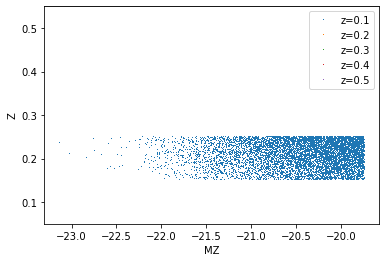

In [437]:
for i in np.arange(5):
    isin = (cats['TOMOGBIN'].data == i)

    pl.plot(cats['MZ'].data[isin], cats['Z'].data[isin], marker=',', lw=0.0, label='z={:.1f}'.format(zs[i]))

pl.axhline(0.55, c='k', lw=0.5)

pl.xlabel('MZ')
pl.ylabel('Z')

pl.ylim(0.05, 0.55)
pl.legend(loc=1)

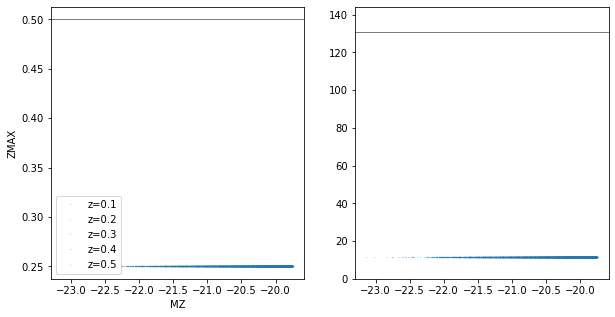

In [438]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i in np.arange(5):
    isin = (cats['TOMOGBIN'].data == i)

    axes[0].plot(cats['MZ'].data[isin],      cats['ZMAX'].data[isin], marker='.', lw=0.0, label='z={:.1f}'.format(zs[i]), markersize=.25)
    axes[1].plot(cats['MZ'].data[isin], 1. / cats['IVMAX'].data[isin] / 1.e8, marker='.', lw=0.0, label='z={:.1f}'.format(zs[i]), markersize=.25)

ylimit = comoving_volume(0.1 - dz/2., 0.55, fsky=1.0) / 1.e8
    
axes[0].axhline(0.5, c='k', lw=0.5)
axes[1].axhline(ylimit, c='k', lw=0.5)

axes[0].set_xlabel('MZ')
axes[0].set_ylabel('ZMAX')
axes[1].set_ylim(0.0, 1.1 * ylimit)
axes[0].legend(loc=3)

Text(0.5, 0, 'Z')

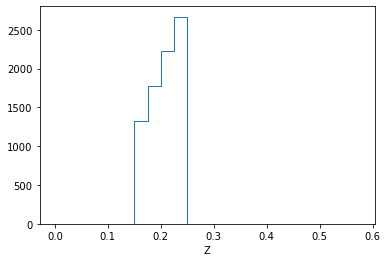

In [439]:
pl.hist(cats['Z'].data, bins=np.arange(0.0, 0.6, 0.025), histtype='step')
pl.xlabel('Z')

Text(0.5, 0, 'VOLUME [1e8 cubic (Mpc/h)]')

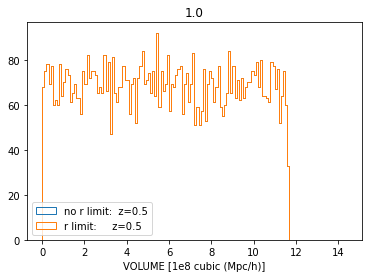

In [441]:
isin = cats['IN_MAGLIM'].data

for i, zz in enumerate(np.arange(0.1, 0.1, 0.1)):
    ylimit = comoving_volume(0.1 - dz/2., zz + 0.05, fsky=1.0) / 1.e8

    pl.axvline(ylimit, c='k', lw=0.5)

pl.hist(cats['VOLUME'].data / 1.e8,       label='no r limit:  z={:.1f}'.format(zs[i]), histtype='step', bins=np.arange(0.0, 14.5, .1))
pl.hist(cats['VOLUME'].data[isin] / 1.e8, label='r limit:     z={:.1f}'.format(zs[i]), histtype='step', bins=np.arange(0.0, 14.5, .1))

pl.title(np.mean(isin))

pl.legend(loc=3, frameon=True)

pl.xlabel('VOLUME [1e8 cubic (Mpc/h)]')

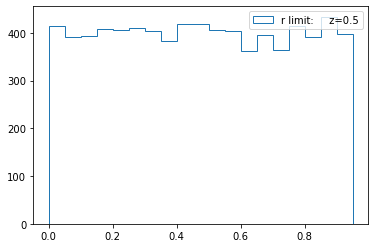

In [442]:
isin = cats['IN_MAGLIM'].data

pl.hist(cats['VOLUME'].data[isin] * cats['IVMAX'].data[isin], label='r limit:     z={:.1f}'.format(zs[i]), histtype='step', bins=np.arange(0.0, 1.0, 0.05))
pl.legend(loc=1, frameon=True)

(10.0, 100000.0)

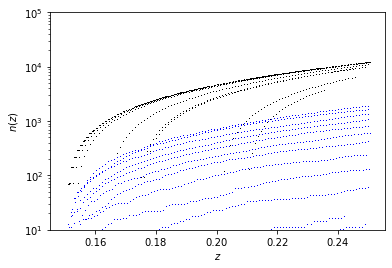

In [443]:
_dz    = 1.e-3

for i in np.unique(cats['MAGBIN'].data):
    isin   = (cats['MAGBIN'].data == i)
    
    zmin   = cats['Z'].data[isin].min()
    zlimit = cats['Z'].data[isin].max()
    
    for x in np.arange(zmin, zlimit + _dz, _dz):
        nn = np.count_nonzero(cats['Z'].data[isin] < x)
        vv = 1.e-5 * comoving_volume(zmin, x, fsky=1.)

        pl.plot(x, nn, marker=',', c='b')
        pl.plot(x, vv, marker=',', c='k')
                    
pl.yscale('log')
pl.xlabel('$z$')
pl.ylabel('$n(z)$')
pl.ylim(1.e1, 1.e5)

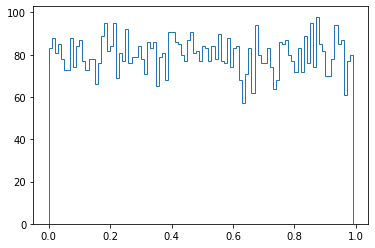

In [444]:
_ = pl.hist(cat['VOLUME'] / cat['VOLUME'].max(), bins=np.arange(0.0, 1.0, 1.e-2), histtype='step')

No handles with labels found to put in legend.


Text(0.5, 0, 'MZREF')

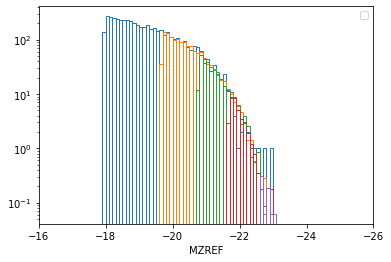

In [386]:
for i, color in zip(np.arange(5), colors):
    isin = (cats['TOMOGBIN'].data == i)
    
    cnts, bins = np.histogram(cats['MZREF'][isin], bins=np.arange(-26., -14., 0.1))
    
    plt.bar(bins[:-1], cnts / rel_norms['RELVOL'].data[i], width=0.1, align='edge', fill=False, edgecolor=color)
        
    pl.yscale('log')
    pl.xlim(-16., -26.)
    
pl.legend(loc=1)

pl.xlabel('MZREF')

No handles with labels found to put in legend.


Text(0.5, 0, 'MZ')

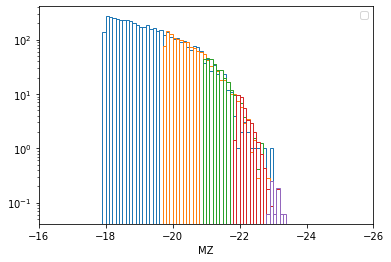

In [387]:
for i, color in zip(np.arange(5), colors):
    isin = (cats['TOMOGBIN'].data == i)
    
    cnts, bins = np.histogram(cats['MZ'][isin], bins=np.arange(-26., -14., 0.1))
    
    plt.bar(bins[:-1], cnts / rel_norms['RELVOL'].data[i], width=0.1, align='edge', fill=False, edgecolor=color)
        
pl.yscale('log')
pl.xlim(-16., -26.)
    
pl.legend(loc=1)
 
pl.xlabel('MZ')

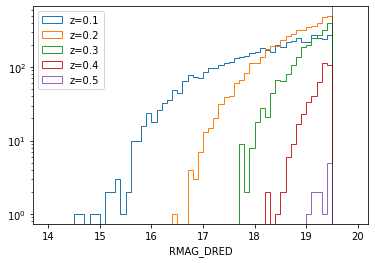

In [388]:
for i in np.arange(5):
    isin = (cats['TOMOGBIN'].data == i)
    
    pl.hist(cats['RMAG_DRED'][isin], bins=np.arange(14., 20., 0.1), histtype='step', label='z={:.1f}'.format(zs[i]))
    pl.yscale('log')
    
pl.xlabel('RMAG_DRED')
pl.axvline(19.5, c='k', lw=0.5)
pl.legend(loc=2)

# Done.